This code requires Python 3.8

In [1]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preprocessing

### Loading the dataset

In [2]:
with open('all_points_may_2024-001.pkl', 'rb') as file:
    df = pickle.load(file)

df = pd.DataFrame(df)
df = df.apply(lambda col: col.map(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x))

df = df.transpose()
print(f'the number of patient is {len(df)}')
df.head()

the number of patient is 190


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....


### Exploration of the dataset

In [3]:
df['Structures']['P186']['1-1-ReAO']['P42'].keys()

dict_keys(['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

## Cleaning the data

### Create a column with the the SOO simplified

In [4]:
labelsDf = pd.read_excel('labels_FontiersUnsupervised.xlsx',sheet_name='Hoja2')
labels = dict(zip(labelsDf['SOO'], labelsDf['Simplified']))
df["Simplified_SOO"] = df["SOO"].map(labels)
df.head()

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures,Simplified_SOO
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....,LVOTSUBVALVULAR
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...,RVOTFREEWALL
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....,RCC
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...,RVOTFREEWALL
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....,RVOTSEPTUM


In [5]:
df.Simplified_SOO.value_counts(dropna=False)

Simplified_SOO
RVOTSEPTUM         60
RVOTFREEWALL       49
LVOTSUBVALVULAR    25
LVOTSUMMIT         22
COMMISURE          13
LCC                12
RCC                 9
Name: count, dtype: int64

## Preparation of the data

In [7]:
df_model = df.copy()
site_1 = "RVOTSEPTUM"
site_2 = "COMMISURE"
site_3 = "RVOT"
site_4 = "LVOT"

df_model[site_1] = df_model["Simplified_SOO"].apply(lambda x:int(x==site_1))
df_model[site_2] = df_model["Simplified_SOO"].apply(lambda x:int(x==site_2))
print(f'total number of {site_1} is {df_model[site_1].sum()}')
print(f'total number of {site_2} is {df_model[site_2].sum()}')

def adjust_values(val):
    if val.startswith('RVOT'):
        return 'RVOT'
    elif val.startswith('LVOT'):
        return 'LVOT'
    else:
        return np.nan  # ou 'autre' ou simplement retourner val pour garder la valeur originale

df_model['classified_SOO'] = df_model['Simplified_SOO'].apply(adjust_values)
# df_model = df_model.dropna(subset=['classified_SOO'])
df_model['RVOT'] = df_model['classified_SOO'].apply(lambda x: 1 if x == 'RVOT' else 0)
df_model['LVOT'] = df_model['classified_SOO'].apply(lambda x: 1 if x == 'LVOT' else 0)
# print(len(df_model))

df_model.head()

total number of RVOTSEPTUM is 60
total number of COMMISURE is 13


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,...,CLINICAL_SCORE,SOO,OTorigin,Structures,Simplified_SOO,RVOTSEPTUM,COMMISURE,classified_SOO,RVOT,LVOT
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,...,NaN,Unión mitroaórtica,0.0,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....,LVOTSUBVALVULAR,0,0,LVOT,0,1
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,...,1.0,Pared libre anterior,1.0,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...,RVOTFREEWALL,0,0,RVOT,1,0
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,...,1.0,RCC,1.0,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....,RCC,0,0,NaN,0,0
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,...,1.0,M. papilar posteromedial,0.0,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...,RVOTFREEWALL,0,0,RVOT,1,0
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,...,1.0,RVOT septal,1.0,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....,RVOTSEPTUM,1,0,RVOT,1,0


In [9]:
df_model.COMMISURE.value_counts()

COMMISURE
0    177
1     13
Name: count, dtype: int64

### Visualization of filtering

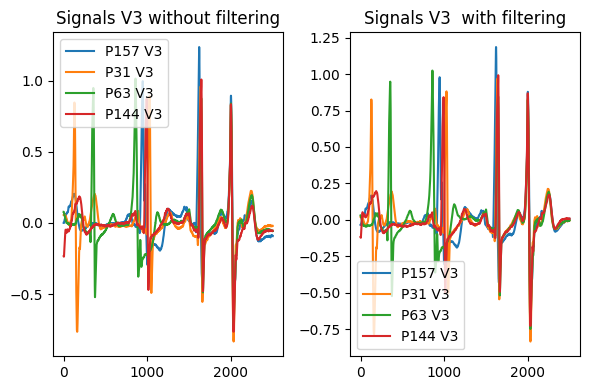

In [11]:
import scipy as sp
def apply_filter(s,fs_high=0.5,fs_low=100):
  s = sp.signal.filtfilt(*sp.signal.butter(2, fs_high/250., 'high'), s, axis=-1)
  s = sp.signal.filtfilt(*sp.signal.butter(2, fs_low/250.,  'low'), s, axis=-1)
  s = sp.signal.detrend(s)
  return s
s1 = df_model['Structures']['P245']['2-RV']['P157']['V3']
s2 = df_model['Structures']['P245']['2-RV']['P31']['V3']
s3 = df_model['Structures']['P245']['2-RV']['P63']['V3']
s4 = df_model['Structures']['P245']['2-RV']['P144']['V3']

fig, axs = plt.subplots(1, 2, figsize=(6, 4))  
axs[0].plot(s1, label='P157 V3')
axs[0].plot(s2, label='P31 V3')
axs[0].plot(s3, label='P63 V3')
axs[0].plot(s4, label='P144 V3')
axs[0].set_title("Signals V3 without filtering")
axs[0].legend()

axs[1].plot(apply_filter(s1), label='P157 V3')
axs[1].plot(apply_filter(s2), label='P31 V3')
axs[1].plot(apply_filter(s3), label='P63 V3')
axs[1].plot(apply_filter(s4), label='P144 V3')
axs[1].set_title("Signals V3  with filtering")
axs[1].legend()

plt.tight_layout()
plt.show()



# Segmentation

SAK needs to be installed from a repository by running pip install git+https://github.com/guillermo-jimenez/sak.git


In [9]:
import torch
import sak
from functools import partial
import math
import scipy as sp
import skimage
import skimage.util
from typing import List,Tuple
import numpy as np
models_ECG = [
    torch.load(f"modelos/model.{i+1}") for i in range(5)
]

c:\Users\asent\anaconda3\envs\CompBioMed2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def predict_ecg(ecg: np.ndarray, fs: float, model: List[torch.nn.Module], 
                window_size: int = 2048, stride: int = 256, threshold_ensemble: float = 0.5, 
                thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16, 
                normalize=True, norm_threshold: float = 1e-6, filter = True) -> np.ndarray:
    """This function is used to delineate an ECG recording of arbitrary size ('ecg' variable, SAMPLES x LEADS) 
    and to obtain the fiducials for the P, QRS and T segments as a binary mask of shape 3 x SAMPLES.
    
    Inputs:
    ecg                <- some array, e.g. shape 198484 x 12
    fs                 <- sampling frequency, e.g. 1000Hz. Will downsample to 250Hz for the AI model to work
    model              <- list of segmentation models for the ensemble
    window_size        <- the "chunk" size that will be processed at a time of the input ecg (e.g., in the example, 
                          2048 samples out of the 198484 samples of the ECG)
    stride             <- the "stride" parameter allows for some overlap between the windows of the window_size
    threshold_ensemble <- Percentage of voting for the AI ensemble [0-1]
    thr_dice           <- Threshold for considering each sample as positive according to the Dice score
    percentile         <- Percentile for the amplitude normalization
    ptg_voting         <- Threshold for considering each sample as positive according to the Dice score
    batch_size         <- Number of windows that fit in the batch
    normalize          <- Boolean to indicate whether the ECG has to be normalized. In general, set this to True
                          always, as the ECGs must have the amplitude of a normal sinus rhythm around amplitude of
                          "1" to work, as that was the preprocessing for model training. Only change if a 
                          comparable pre-processing is performed
    norm_threshold     <- Threshold for the normalization, to avoid passing baseline wander or noise as signal
    filter             <- Filter the signal with a band-pass filter in [0.5-125] Hz
    """
    # Preprocess signal
    ecg = np.copy(ecg).squeeze()
    if ecg.ndim == 0:
        return np.array([])
    elif ecg.ndim == 1:
        ecg = ecg[:,None]
    elif ecg.ndim == 2:
        if ecg.shape[0] < ecg.shape[1]:
            ecg = ecg.T
    else:
        raise ValueError("2 dims max allowed")
    ecg_250 = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[0]*250/fs),axis=0)


    # Pad if necessary
    if ecg_250.shape[0] < window_size:
        padding = math.ceil(ecg_250.shape[0]/window_size)*window_size-ecg_250.shape[0]
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')
    if (ecg_250.shape[0]-window_size)%stride != 0:
        padding = math.ceil((ecg_250.shape[0]-window_size)/stride)*stride-(ecg_250.shape[0]%window_size)
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')

    # Get dimensions
    N,L = ecg_250.shape

    # (Optional) Normalize amplitudes
    if normalize:
        # Get ecg_250 when it's not flat zero
        norm_signal = ecg_250[np.all(np.abs(np.diff(ecg_250,axis=0,append=0)) >= norm_threshold,axis=1),:]

        # High pass filter normalized ecg_250 to avoid issues with baseline wander
        norm_signal = sp.signal.filtfilt(*sp.signal.butter(2, 0.5/250., 'high'),norm_signal, axis=0)

        # Compute amplitude for those segments
        amplitude = np.array(sak.signal.moving_lambda(
            norm_signal,
            256,
            partial(sak.signal.amplitude,axis=0),
            axis=0
        ))
        amplitude = amplitude[np.all(amplitude > norm_threshold,axis=1),]
        amplitude = np.percentile(amplitude, percentile, axis=0)

        # Apply normalization
        ecg_250 = ecg_250/amplitude[None,:]

    # (Optional) Filter ecg_250
    if filter:
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/250., 'high'),ecg_250,axis=0)
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2, 125.0/250.,  'low'),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,250.),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,250.),ecg_250,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(ecg_250.strides) < 0):
        ecg_250 = ecg_250.copy()

    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(ecg_250,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=int)
    
    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Compute segmentation for all leads independently
    with torch.no_grad():
        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                for i in range(0,windowed_signal.shape[0],batch_size):
                    inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                    windowed_mask[i:i+batch_size] += outputs > thr_dice
            windowed_mask = windowed_mask >= len(model)*threshold_ensemble
        else:
            model = model.to(device)
            for i in range(0,windowed_signal.shape[0],batch_size):
                inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).to(device).float()}
                outputs = model(inputs)["sigmoid"].cpu().detach().numpy()
                windowed_mask[i:i+batch_size] = outputs > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation_250 = np.zeros((3,N))
        
    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation_250[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation_250 = ((segmentation_250/counter) >= (ecg_250.shape[-1]*ptg_voting))

    # Correct padding
    segmentation_250 = segmentation_250[:,:-padding]

    # Interpolate back to original sampling frequency
    segmentation     = sak.signal.interpolate.interp1d(segmentation_250,ecg.shape[0],axis=-1,kind="nearest")

    return segmentation


In [11]:
#Transform the signal from dictionary to numpy array
from sak.signal import StandardHeader
signals = df_model['Structures']['P152']['3-RA']['P6']
signals = df_model['Structures']['P152']['3-RA']['P1']
# signals = df_train.iloc[0]['Structures']['1-1-Rp-PA']['EEVV']
fs = 1000
fs_high,fs_low = 0.5,100.0
start_signal = 1500

def get_signals(signals,with_segmentation = False):
    ecg_signals = []
    for lead in StandardHeader:
        ecg_signals.append(signals[lead])
    ecg_signals = np.asarray(ecg_signals).T
    if with_segmentation:
        ecg_250 = sak.signal.interpolate.interp1d(ecg_signals,round(ecg_signals.shape[0]*250/fs), axis=0).T
        segmentation_250 = predict_ecg(ecg_250,250.,models_ECG,normalize=True,filter=False)
        segmentation = sak.signal.interpolate.interp1d(segmentation_250,ecg_signals.shape[0],axis=-1,kind="nearest")
    else:
        segmentation = None
        ecg_250 = ecg_signals.T
        
    ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2, fs_high/250., 'high'), ecg_250, axis=-1)
    ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2,  fs_low/250.,  'low'), ecg_250, axis=-1)
    return ecg_signals.T, segmentation

def get_pic(signal):
    max_value = signal.max()
    max_index = np.argmax(signal)
    return max_value,max_index


ecg_signals, segmentation = get_signals(signals,with_segmentation=True)

new_sig = ecg_signals * segmentation[1]

### Functions for one signal

(1933, 2029)

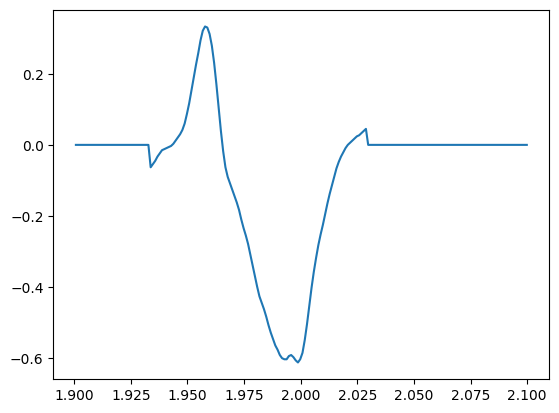

In [12]:
import matplotlib.pyplot as plt
def visualize(ecg_signals,segmentation):
  x = np.linspace(0,2.5,int(fs*2.5))
  y = ecg_signals[8]
  plt.plot(x[1900:2100],y[1900:2100]);
  pass

def find_pic(segmentation):
    pic = 2000
    start_index = None
    start_pic = None
    end_pic = None
    in_true_seq = False
    for i, value in enumerate(segmentation[1,1500:], start=1500):
        if value == True and not in_true_seq:
            in_true_seq = True
            start_index = i
            
        elif value == True and i ==pic:
            start_pic = start_index
            
        elif value == False and in_true_seq:
            in_true_seq = False
            if start_pic!= None:
                end_pic = i
                break
    if start_pic ==None or end_pic==None:
        return 0,2500 # the maximum wil be discarded b len_<200
    return start_pic, end_pic
  
  
visualize(new_sig,segmentation)
find_pic(segmentation)

### Visualization of all leads

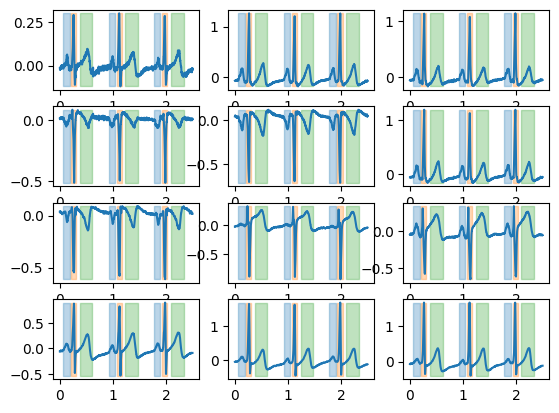

In [13]:
def visualize_seg(ecg_signals,segmentation):
    #Plot all the signals
    fig, ax = plt.subplots(4,3)
    row = 0
    col = 0
    x = np.linspace(0,2.5,int(fs*2.5))
    for i,sig in enumerate(ecg_signals):
        ax[row,col].plot(x, sig)
        ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[0,:] == 1), color='C0', alpha = 0.3 )
        ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[1,:] == 1), color='C1', alpha = 0.3 )
        ax[row,col].fill_between(x, np.min(sig), np.max(sig), where=(segmentation[2,:] == 1), color='C2', alpha = 0.3 )
        col += 1
        if col >= 3:
            row += 1
            col = 0
    pass

 
visualize_seg(ecg_signals,segmentation)

### Extract info about the pics of V3 and put them in a dataframe

In [14]:
def get_pics_df(df):
  new_df = df.copy()
  new_df['avg_max_val'] = 0 
  new_df['index_max_val'] = 0 
  new_df['length_seg'] = 2500
  
  for index, row in new_df.iterrows():
    treated = False
    lead = 8 #V3
    structures = row['Structures']
    if structures != None:
      for _, structure in structures.items():
        for _,points in structure.items():
          if treated :
            break
          ecg_signals, segmentation = get_signals(signals=points,with_segmentation=True)
          start_pic,end_pic = find_pic(segmentation)
          new_sig = ecg_signals * segmentation[1]
          max_val,index_max_val = get_pic(new_sig[lead][start_pic:end_pic])
          treated = True
          l = end_pic - start_pic
          
    new_df.at[index, 'avg_max_val'] = max_val 
    new_df.at[index, 'index_max_val'] = index_max_val
    if l == 2500:
      new_df.at[index, 'length_seg'] = None
    else:
      new_df.at[index, 'length_seg'] = index_max_val
      
  return new_df

new_df = get_pics_df(df_model) 
new_df.head() 

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,...,Structures,Simplified_SOO,RVOTSEPTUM,COMMISURE,classified_SOO,RVOT,LVOT,avg_max_val,index_max_val,length_seg
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,...,{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....,LVOTSUBVALVULAR,0,0,LVOT,0,1,1.305,64,64.0
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,...,{'2-RV': {'P157': {'I': [ 0. 0. 0. ...,RVOTFREEWALL,0,0,RVOT,1,0,0.894,55,55.0
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,...,{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....,RCC,0,0,NaN,0,0,0.975,65,65.0
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,...,{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...,RVOTFREEWALL,0,0,RVOT,1,0,0.363,41,41.0
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,...,{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....,RVOTSEPTUM,1,0,RVOT,1,0,0.681,83,83.0


### Save the dataframe to use it in collab for Gpu

In [ ]:
new_df.to_excel("df_with_max_value.xlsx")

## Training


In [48]:
target = site_4

df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=42, stratify=new_df[target])
min_start_pic = 1900
max_end_pic = 2100

In [49]:
def training_dataset(target,df):
  X =[] 
  y =[] 
  patient = []
  i = 0
  for index, row in df.iterrows():
      label = row[target]
      structures = row['Structures']
      if structures != None:
        for _, structure in structures.items():
          for _,points in structure.items():
            ecg_signals, _ = get_signals(signals=points,with_segmentation=False)
            X.append(ecg_signals[:,min_start_pic:max_end_pic])
            y.append(label) 
            patient.append(index) 
            i+=1
            print(f"Progression : {i} ", end="\r")
        
  X = torch.tensor(np.array(X))
  print(f'X shape is {X.shape}')
  
  y = torch.tensor(np.array(y))
  return X,y,patient

sig,y,patient_train = training_dataset(target,df_train)

X shape is torch.Size([25118, 12, 200])


## Testing

In [50]:
def testing_dataset(target,df):
  X =[] 
  y =[]
  patient = [] 
  i = 0
  for index, row in df.iterrows():
      treated = False
      label = row[target]
      structures = row['Structures']
      if structures != None:
        for _, structure in structures.items():
          for _,points in structure.items():
            if treated :
              break
            ecg_signals, _ = get_signals(signals=points,with_segmentation=False)
            X.append(ecg_signals[:,min_start_pic:max_end_pic])
            y.append(label) 
            patient.append(index) 
            i+=1
            treated = True
            print(f"Progression : {i} ", end="\r")
        
            # treated = True
  X = torch.tensor(np.array(X))
  print(f'X shape is {X.shape}')
  
  y = torch.tensor(np.array(y))
  return X,y,patient

sig_test,y_test,patient_test = training_dataset(target,df_test)

X shape is torch.Size([4035, 12, 200])


In [51]:
torch.save({'X_train': sig, 'y_train': y, 'patient_id_train': patient_train,
            'X_test' : sig_test,'y_test':y_test,  'patient_id_test': patient_test}, 
           'data_'+target+'.pth')